# Complete Flow Example
This norebook uses the pipeline to first infer the municipalities that share the same influences over the malaria cases (weekly) and then uses the output to find the metaregions that arise from mobility. 

In [1]:
import sys
sys.path.append('src/')


In [2]:
# Useful imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from utils.publication_functions import beautify_data_column_name
from sklearn.cluster import KMeans
from flows.specific.custom_flow import CustomFlow
import geopandas as gpd

# Data sources
from data_sources.specific.malaria_falciparum_cases_sivigila import MalariaFalciparumSivigila4
from data_sources.specific.malaria_vivax_cases_sivigila import MalariaVivaxSivigila4
from data_sources.specific.gold_export import GoldExport

import yfinance as yf

# Embedders
from embedders.specific.identity_embedder import IdentityEmbbeder


# Clusteres
from clusterers.specific.identity_clusterer import IdentityClusterer


# Geographies
from geography.specific.colombian_municipalities import ColombianMunicipalities

pd.set_option('display.max_rows', 100)



/home/minigonche/Dropbox/Projects/pathogen_study_regions_generator/env/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. Cluster by Mobility

In [3]:
included_sources = [MalariaFalciparumSivigila4]#, MalariaVivaxSivigila4, GoldExport]
included_matrix_sources =  []
#target_mobility_col = "fb_mobility_recent_movement"


flow1 = CustomFlow(ID = 'vivax_falciparum',
                    name = "Vivax and Falciparum",
                    time_resolution = MONTH,
                    geography= ColombianMunicipalities(),
                    vector_data_sources=included_sources,
                    matrix_data_sources=included_matrix_sources,
                    embedder=[IdentityEmbbeder()],
                    clusterer=IdentityClusterer())
                    #embedder=LinearRegressionCoefficientEmbedder(target_col=target_col),
                    #clusterer=SklearnVectorClusterer(ID="kmeans", name="K-Means", sklearn_clusterer= KMeans(n_clusters=5)))


#flow1.run()

In [3]:
df_muni= gpd.read_file("/home/minigonche/Dropbox/Projects/malaria_mining/data/raw/geo/Municpios_Dane_2017/Municpios_Dane_2017.shp")


In [4]:
df_muni = df_muni[["Departamen","Municipio","Codigo_Dan", "Pob_Urbana","Pob_Rural","Total_2018", "geometry"]].copy()
df_muni = df_muni.rename(columns = {"Codigo_Dan" : "ID", 
                                    "Pob_Urbana" : "total_poblacion_urbana", 
                                    "Pob_Rural" : "total_poblacion_rural",
                                    "Total_2018" : "total_poblacion"})
df_muni["ID"] = df_muni["ID"].astype(int) 
df_muni

,Departamen,Municipio,ID,total_poblacion_urbana,total_poblacion_rural,total_poblacion,geometry
0,ANTIOQUIA,MONTEBELLO,5467,2010.0,3815.0,5825.0,"POLYGON ((834479.411 1157896.499, 834511.481 1..."
1,ANTIOQUIA,MURINDO,5475,950.0,3941.0,4891.0,"POLYGON ((713271.562 1269173.628, 713286.189 1..."
2,ANTIOQUIA,MUTATA,5480,5910.0,16118.0,22028.0,"POLYGON ((733448.227 1327312.596, 733432.222 1..."
3,ANTIOQUIA,ENVIGADO,5266,230635.0,7538.0,238173.0,"POLYGON ((844130.008 1176411.448, 844154.320 1..."
4,ANTIOQUIA,NARINO,5483,2504.0,15387.0,17891.0,"POLYGON ((870771.822 1119962.751, 870807.634 1..."
...,...,...,...,...,...,...,...
1117,VAUPES,YAVARATE (Cor. Departamental),97889,0.0,1226.0,1226.0,"POLYGON ((1454658.844 552386.480, 1448299.610 ..."
1118,VICHADA,PUERTO CARRENO,99001,13986.0,2518.0,16504.0,"POLYGON ((1698922.296 1193595.360, 1698936.168..."
1119,VICHADA,LA PRIMAVERA,99524,9744.0,7282.0,17026.0,"POLYGON ((1559216.945 1179280.462, 1559607.066..."
1120,VICHADA,SANTA ROSALIA,99624,2810.0,1387.0,4197.0,"POLYGON ((1381111.505 1089754.313, 1381112.010..."


In [5]:
df_malaria= pd.read_csv("/home/minigonche/Dropbox/Projects/malaria_mining/data/pipeline_data/raw/malaria_cases/sivigila_4.csv", parse_dates=["date"])
df_mining = pd.read_csv("/home/minigonche/Dropbox/Projects/malaria_mining/data/pipeline_data/raw/gold_exports/gold_exports.csv", parse_dates=["date"])



In [6]:
df_mining = df_mining.rename(columns = {"grams":"gold_exports", "muni_id" : "ID"})

In [6]:
df_malaria = df_malaria.rename(columns = {"grams" : "gold_exports", "muni_id" : "ID"})
df_malaria["date"] = df_malaria["date"].astype("datetime64[M]")
df_malaria = df_malaria[df_malaria.date.dt.year >= 2007].copy()
df_malaria = df_malaria[df_malaria.date.dt.year < 2021].copy()
df_malaria = df_malaria.groupby(["date","nombre_evento","ID"]).sum().reset_index()
df_malaria = df_malaria[df_malaria["nombre_evento"].isin(["MALARIA FALCIPARUM","MALARIA VIVAX"])].copy()
df_malaria

,date,nombre_evento,ID,num_cases
24,2007-01-01,MALARIA FALCIPARUM,0,1
25,2007-01-01,MALARIA FALCIPARUM,5000,1
26,2007-01-01,MALARIA FALCIPARUM,5250,1
27,2007-01-01,MALARIA FALCIPARUM,5659,1
28,2007-01-01,MALARIA FALCIPARUM,5736,1
...,...,...,...,...
54696,2020-12-01,MALARIA VIVAX,95200,7
54697,2020-12-01,MALARIA VIVAX,97511,4
54698,2020-12-01,MALARIA VIVAX,97666,2
54699,2020-12-01,MALARIA VIVAX,99001,1


In [8]:
df_malaria_yearly = df_malaria.copy()
df_malaria_yearly["date"] = df_malaria_yearly["date"].astype("datetime64[Y]")
df_malaria_yearly = df_malaria_yearly.groupby(["date","nombre_evento","ID"]).sum().reset_index()
df_piv = df_malaria_yearly.pivot(index = ["ID","date"], columns = ["nombre_evento"], values = "num_cases").fillna(0).reset_index()
df_piv["TOTAL"] = df_piv["MALARIA FALCIPARUM"] + df_piv["MALARIA VIVAX"] 
df_piv

nombre_evento,ID,date,MALARIA FALCIPARUM,MALARIA VIVAX,TOTAL
0,0,2007-01-01,36.0,46.0,82.0
1,0,2008-01-01,20.0,64.0,84.0
2,0,2009-01-01,16.0,43.0,59.0
3,0,2010-01-01,13.0,50.0,63.0
4,0,2011-01-01,508.0,534.0,1042.0
...,...,...,...,...,...
6317,99773,2016-01-01,263.0,721.0,984.0
6318,99773,2017-01-01,365.0,789.0,1154.0
6319,99773,2018-01-01,127.0,345.0,472.0
6320,99773,2019-01-01,72.0,749.0,821.0


In [9]:
def fun(df):

    ids = df["ID"].copy()
    df = 100*df/df.sum()
    df["ID"] = ids

    return(df)



df_piv_perc = df_piv.groupby(['date']).apply(fun)
df_piv_perc["date"] = df_piv["date"]



In [10]:
target = 60

dfs = []

for col in ["MALARIA FALCIPARUM", "MALARIA VIVAX", "TOTAL"]:

    for d in df_piv_perc.date.unique():
        df_temp = df_piv_perc.loc[df_piv_perc["date"] == d,["date","ID",col]]
        df_temp = df_temp.sort_values(col, ascending = False)
        df_temp["cum"] = df_temp[col].cumsum()
        t = np.where(df_temp["cum"] > target)[0][0] + 1

        print(f"{col} Cutoff: {np.round(df_temp[col].values[t + 1],2)} ({df_temp['ID'].values[t+1]})")
        df_temp = df_temp[['ID']].head(t)
        df_temp["count"] = 1

        dfs.append(df_temp)


df_sel = pd.concat(dfs, ignore_index=True).groupby("ID").sum().sort_values("count",ascending=False).reset_index() 
df_sel

MALARIA FALCIPARUM Cutoff: 3.46 (27001)
MALARIA FALCIPARUM Cutoff: 1.98 (27025)
MALARIA FALCIPARUM Cutoff: 2.36 (95200)
MALARIA FALCIPARUM Cutoff: 2.15 (27600)
MALARIA FALCIPARUM Cutoff: 2.17 (23807)
MALARIA FALCIPARUM Cutoff: 1.96 (52696)
MALARIA FALCIPARUM Cutoff: 2.62 (27413)
MALARIA FALCIPARUM Cutoff: 2.03 (19809)
MALARIA FALCIPARUM Cutoff: 2.6 (19318)
MALARIA FALCIPARUM Cutoff: 2.73 (76109)
MALARIA FALCIPARUM Cutoff: 2.78 (76109)
MALARIA FALCIPARUM Cutoff: 2.05 (19318)
MALARIA FALCIPARUM Cutoff: 2.33 (27361)
MALARIA FALCIPARUM Cutoff: 2.39 (27413)
MALARIA VIVAX Cutoff: 1.27 (54810)
MALARIA VIVAX Cutoff: 1.25 (86568)
MALARIA VIVAX Cutoff: 1.3 (66572)
MALARIA VIVAX Cutoff: 1.51 (95015)
MALARIA VIVAX Cutoff: 1.53 (5604)
MALARIA VIVAX Cutoff: 1.7 (66572)
MALARIA VIVAX Cutoff: 1.39 (27580)
MALARIA VIVAX Cutoff: 1.43 (95001)
MALARIA VIVAX Cutoff: 1.76 (23466)
MALARIA VIVAX Cutoff: 1.71 (23855)
MALARIA VIVAX Cutoff: 1.53 (5895)
MALARIA VIVAX Cutoff: 1.74 (91540)
MALARIA VIVAX Cutoff: 1.9

nombre_evento,ID,count
0,27001,33
1,5250,32
2,23807,29
3,52835,27
4,23580,25
5,52490,24
6,52621,24
7,27787,20
8,76109,19
9,5895,19


Text(0.5, 1.0, 'malaria MALARIA VIVAX')

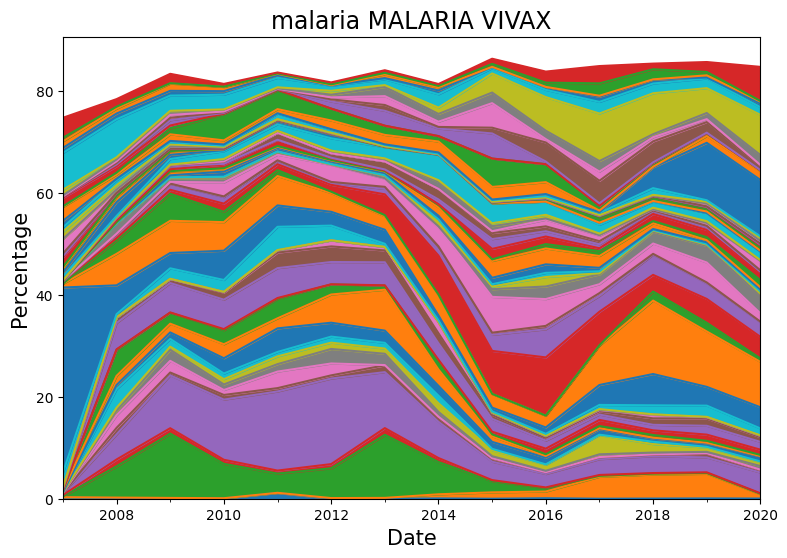

In [11]:
col = ["MALARIA FALCIPARUM", "MALARIA VIVAX", "TOTAL"][1]
selected = df_sel.ID.values 

year_countries = df_piv_perc[df_piv_perc.ID.isin(selected)].pivot(index="date", columns="ID", values = col)


# plot
ax = year_countries.plot(kind='area', figsize=(9, 6), legend=False)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_title(f'malaria {col}', fontsize=17)


<AxesSubplot:xlabel='date', ylabel='num_cases'>

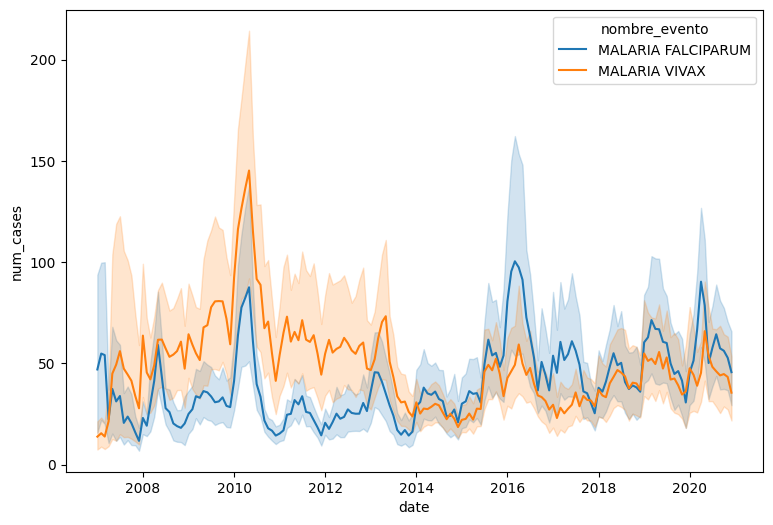

In [13]:
plt.figure(figsize=(9, 6))
sns.lineplot(data = df_malaria[df_malaria.ID.isin(selected)], x = "date", y = "num_cases", hue = "nombre_evento")

In [14]:
df_selected = df_malaria.copy()
df_selected["date"] = df_selected["date"].astype("datetime64[M]")
df_selected = df_selected.groupby(["date","nombre_evento","ID"]).sum().reset_index()
df_selected = df_selected.pivot(index = ["ID","date"], columns = ["nombre_evento"], values = "num_cases").fillna(0).reset_index()
df_selected["TOTAL"] = df_selected["MALARIA FALCIPARUM"] + df_selected["MALARIA VIVAX"] 


df_selected["moment"] = 0
df_selected.loc[df_selected.date.dt.year >= 2014, "moment"] = 1
df_totals = df_selected[["ID", "MALARIA FALCIPARUM","MALARIA VIVAX","TOTAL","moment"]].groupby(["ID", "moment"]).sum().reset_index()
df_totals["PROP_FACIPARUM"] = 100*(df_totals["MALARIA FALCIPARUM"] / df_totals["TOTAL"])


df_totals = df_totals[["ID","TOTAL","moment","PROP_FACIPARUM", "MALARIA FALCIPARUM", "MALARIA VIVAX"]].pivot(index="ID", columns="moment", values=["TOTAL","PROP_FACIPARUM", "MALARIA VIVAX","MALARIA FALCIPARUM"])


df_totals["CASES_PERIOD_1"] = df_totals["TOTAL",0] 
df_totals["CASES_VIVAX_PERIOD_1"] = df_totals["MALARIA VIVAX",0] 
df_totals["CASES_FALCIPARUM_PERIOD_1"] = df_totals["MALARIA FALCIPARUM",0] 
df_totals["CASES_PERIOD_2"] = df_totals["TOTAL",1] 
df_totals["CASES_VIVAX_PERIOD_2"] = df_totals["MALARIA VIVAX",1] 
df_totals["CASES_FALCIPARUM_PERIOD_2"] = df_totals["MALARIA FALCIPARUM",1] 
df_totals["DIFF_CASES"] = df_totals["TOTAL",1] - df_totals["TOTAL",0]
df_totals["DIFF_CASES_FALCIPARUM"] = df_totals["MALARIA FALCIPARUM",1] - df_totals["MALARIA FALCIPARUM",0]
df_totals["DIFF_CASES_VIVAX"] = df_totals["MALARIA VIVAX",1] - df_totals["MALARIA VIVAX",0]
df_totals["DIFF_PROP"] = (df_totals["PROP_FACIPARUM",1] - df_totals["PROP_FACIPARUM",0]) 
df_totals["PROP_FALC"] = 100*df_totals["MALARIA FALCIPARUM",1]/df_totals["MALARIA FALCIPARUM",1].sum()
df_totals["PROP_VIVAX"] = 100*df_totals["MALARIA VIVAX",1]/df_totals["MALARIA VIVAX",1].sum()

df_totals = df_totals.reset_index()


df_totals = df_totals[["ID", 
                        "CASES_PERIOD_1", 
                        "CASES_VIVAX_PERIOD_1",
                        "CASES_FALCIPARUM_PERIOD_1",
                        "CASES_PERIOD_2", 
                        "CASES_VIVAX_PERIOD_2",
                        "CASES_FALCIPARUM_PERIOD_2",
                        "DIFF_CASES",
                        "DIFF_CASES_FALCIPARUM",
                        "DIFF_CASES_VIVAX",
                        "PROP_FALC",
                        "PROP_VIVAX"]]

df_totals = df_totals.droplevel(level = 1, axis = 1)


df_mining_totals = df_mining[["ID","gold_exports"]].groupby("ID").sum().reset_index()
df_totals = df_totals.merge(df_mining_totals, how= "left").fillna(0)
df_totals

q = [0.25,0.5,0.75]
qs = np.quantile(df_totals.gold_exports,q)

df_totals["gold_export_group"] = 0

for i in range(len(q)):
    df_totals.loc[df_totals["gold_exports"] > qs[i], "gold_export_group"] = i + 1

df_totals = df_muni.merge(df_totals, how = "right")

df_totals = df_totals[df_totals.ID.isin(selected)].copy()

df_totals.sort_values("ID")

,Departamen,Municipio,ID,total_poblacion_urbana,total_poblacion_rural,total_poblacion,geometry,CASES_PERIOD_1,CASES_VIVAX_PERIOD_1,CASES_FALCIPARUM_PERIOD_1,CASES_PERIOD_2,CASES_VIVAX_PERIOD_2,CASES_FALCIPARUM_PERIOD_2,DIFF_CASES,DIFF_CASES_FALCIPARUM,DIFF_CASES_VIVAX,PROP_FALC,PROP_VIVAX,gold_exports,gold_export_group
0,NaN,NaN,0,NaN,NaN,NaN,None,1332.0,739.0,593.0,135.0,90.0,45.0,-1197.0,-548.0,-649.0,0.019106,0.042603,0.0,0
38,NaN,NaN,1862,NaN,NaN,NaN,None,304.0,264.0,40.0,6461.0,5587.0,874.0,6157.0,834.0,5323.0,0.371089,2.644709,0.0,0
62,ANTIOQUIA,CACERES,5120,9461.0,31551.0,41012.0,"POLYGON ((875389.739 1371801.737, 875418.632 1...",27567.0,24162.0,3405.0,2623.0,2250.0,373.0,-24944.0,-3032.0,-21912.0,0.158371,1.065079,7196678.0,3
71,ANTIOQUIA,CAUCASIA,5154,100058.0,20421.0,120479.0,"POLYGON ((907308.033 1386747.611, 907316.693 1...",3507.0,3011.0,496.0,498.0,417.0,81.0,-3009.0,-415.0,-2594.0,0.034392,0.197395,28890964.0,3
81,ANTIOQUIA,EL BAGRE,5250,26120.0,24437.0,50557.0,"POLYGON ((920969.941 1375912.517, 920854.621 1...",48215.0,36626.0,11589.0,10056.0,7700.0,2356.0,-38159.0,-9233.0,-28926.0,1.000327,3.644936,52164177.0,3
106,ANTIOQUIA,MUTATA,5480,5910.0,16118.0,22028.0,"POLYGON ((733448.227 1327312.596, 733432.222 1...",2787.0,2697.0,90.0,1263.0,1061.0,202.0,-1524.0,112.0,-1636.0,0.085767,0.502244,1075502.0,3
108,ANTIOQUIA,NECOCLI,5490,16703.0,50656.0,67359.0,"POLYGON ((719552.173 1455995.012, 719536.683 1...",6242.0,5838.0,404.0,493.0,183.0,310.0,-5749.0,-94.0,-5655.0,0.131622,0.086626,0.0,0
109,ANTIOQUIA,NECHI,5495,15298.0,13287.0,28585.0,"POLYGON ((916974.775 1398555.316, 917183.271 1...",5896.0,5282.0,614.0,1097.0,1001.0,96.0,-4799.0,-518.0,-4281.0,0.040760,0.473842,5516236.0,3
117,ANTIOQUIA,REMEDIOS,5604,11485.0,19848.0,31333.0,"POLYGON ((965572.105 1295372.035, 965585.416 1...",3352.0,3106.0,246.0,3479.0,3041.0,438.0,127.0,192.0,-65.0,0.185969,1.439513,34513526.0,3
131,ANTIOQUIA,SAN PEDRO DE URABA,5665,14762.0,17301.0,32063.0,"POLYGON ((762261.656 1441257.003, 762309.967 1...",4973.0,4741.0,232.0,812.0,679.0,133.0,-4161.0,-99.0,-4062.0,0.056470,0.321417,0.0,0


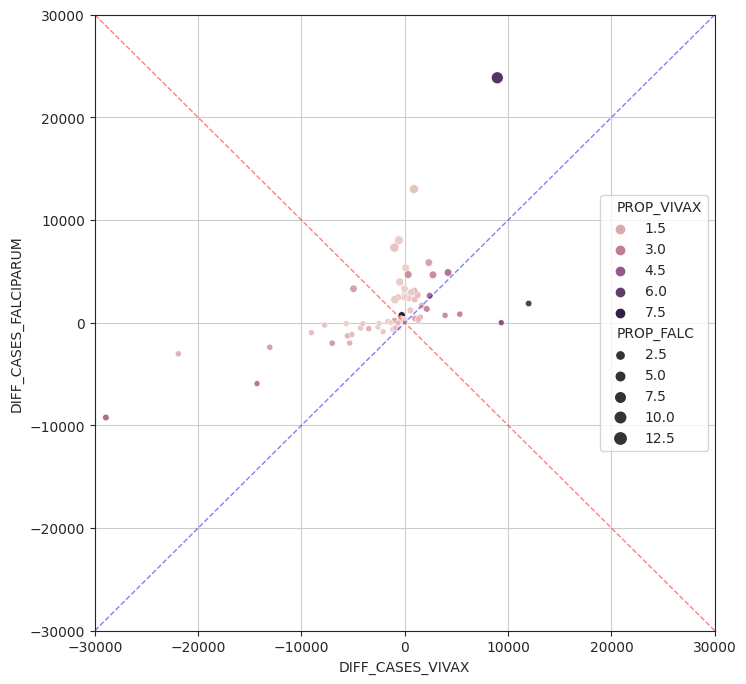

In [15]:
sns.set_style("ticks",{'axes.grid' : True})
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(data = df_totals, x = "DIFF_CASES_VIVAX", y = "DIFF_CASES_FALCIPARUM", hue="PROP_VIVAX", legend=True, size="PROP_FALC")

ax.axline(xy1 = (0,0), slope=-1, ls="--", c="red",lw = 1, alpha = 0.5)
ax.axline(xy1 = (0,0), slope=1, ls="--", c="blue",lw = 1, alpha = 0.5)
plt.ylim(-30000, 30000)
plt.xlim(-30000, 30000)
plt.show()

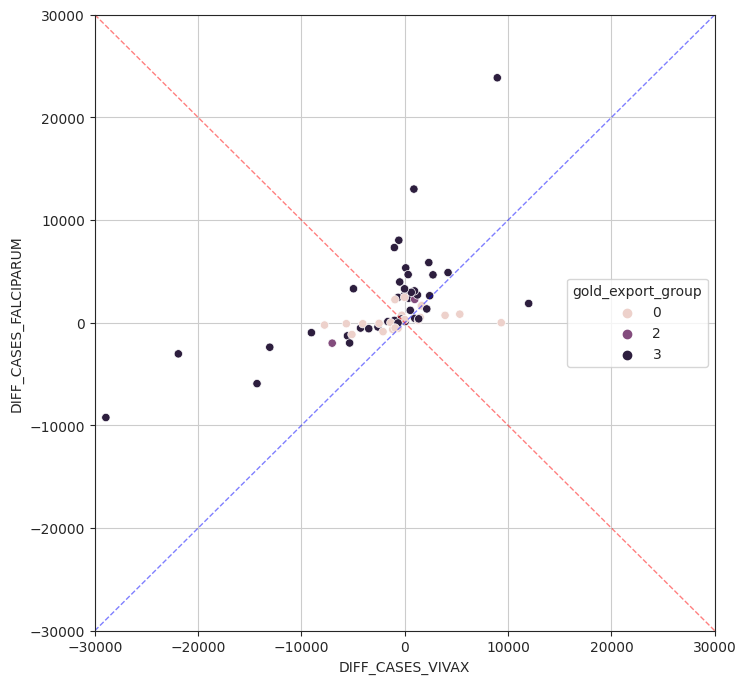

In [16]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data = df_totals, x = "DIFF_CASES_VIVAX", y = "DIFF_CASES_FALCIPARUM", hue="gold_export_group", legend=True)

ax.axline(xy1 = (0,0), slope=-1, ls="--", c="red",lw = 1, alpha = 0.5)
ax.axline(xy1 = (0,0), slope=1, ls="--", c="blue",lw = 1, alpha = 0.5)
plt.ylim(-30000, 30000)
plt.xlim(-30000, 30000)
plt.show()

In [17]:
df_totals[df_totals.ID == 1862]

,Departamen,Municipio,ID,total_poblacion_urbana,total_poblacion_rural,total_poblacion,geometry,CASES_PERIOD_1,CASES_VIVAX_PERIOD_1,CASES_FALCIPARUM_PERIOD_1,CASES_PERIOD_2,CASES_VIVAX_PERIOD_2,CASES_FALCIPARUM_PERIOD_2,DIFF_CASES,DIFF_CASES_FALCIPARUM,DIFF_CASES_VIVAX,PROP_FALC,PROP_VIVAX,gold_exports,gold_export_group
38,NaN,NaN,1862,NaN,NaN,NaN,None,304.0,264.0,40.0,6461.0,5587.0,874.0,6157.0,834.0,5323.0,0.371089,2.644709,0.0,0


In [18]:
df_totals.to_csv("diff_cases_malaria_2007_2020.csv", index = False)

# Comparison 

In [15]:
df_mining

,date,ID,gold_exports
0,2012-01-01,5001.0,60369.0
1,2012-01-01,5004.0,701.0
2,2012-01-01,5031.0,44193.0
3,2012-01-01,5034.0,1691.0
4,2012-01-01,5038.0,19221.0
...,...,...,...
4341,2021-01-04,73217.0,41407.0
4342,2021-01-04,73411.0,48438.0
4343,2021-01-04,73686.0,2875.0
4344,2021-01-04,76109.0,133.0


In [47]:
df_plot = df_malaria.copy()
df_plot = df_plot[["date","nombre_evento","num_cases"]].groupby(["date","nombre_evento"]).sum().reset_index()


df_vivax_plot = df_plot[df_plot.nombre_evento == "MALARIA VIVAX"].copy()
df_vivax_plot = df_vivax_plot[["date","num_cases"]]
df_vivax_plot.columns = ["date","MALARIA VIVAX"]

df_falciparum_plot = df_plot[df_plot.nombre_evento == "MALARIA FALCIPARUM"].copy()
df_falciparum_plot = df_falciparum_plot[["date","num_cases"]]
df_falciparum_plot.columns = ["date","MALARIA FALCIPARUM"]



[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='date', ylabel='gold_stock_price'>

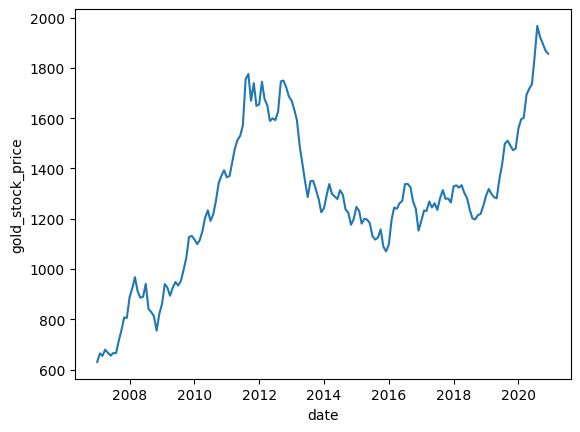

In [56]:
df_gold_price = yf.download("GC=F", period="max")
df_gold_price = df_gold_price.reset_index()
df_gold_price = df_gold_price[["Date","Open"]].copy()
df_gold_price.columns = ["date","gold_stock_price"]
df_gold_price = df_gold_price[df_gold_price.date >= pd.to_datetime("2007-01-01")]
df_gold_price = df_gold_price[df_gold_price.date < pd.to_datetime("2021-01-01")]
df_gold_price["date"] = df_gold_price["date"].astype("datetime64[M]")
df_gold_price = df_gold_price.groupby("date").mean().reset_index()


sns.lineplot(data = df_gold_price, x = "date", y = "gold_stock_price")

<AxesSubplot:xlabel='date', ylabel='gold_exports'>

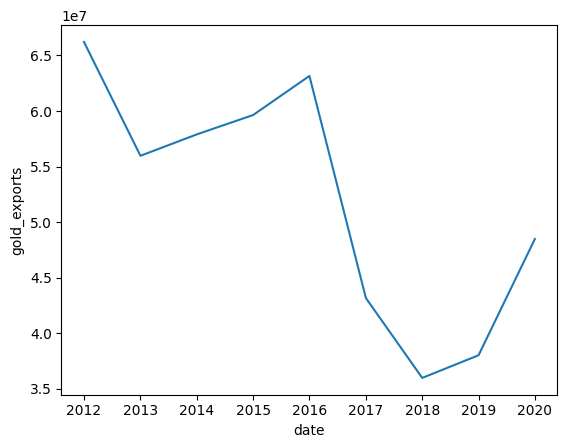

In [49]:
df_mining_plot = df_mining.copy()
df_mining_plot["date"] = df_mining_plot["date"].astype("datetime64[M]")
df_mining_plot = df_mining_plot[["date","gold_exports"]].groupby("date").sum().reset_index()
df_mining_plot = df_mining_plot[df_mining_plot.date.dt.year <= 2020]


sns.lineplot(data = df_mining_plot, x = "date", y = "gold_exports")

<AxesSubplot:xlabel='date', ylabel='total'>

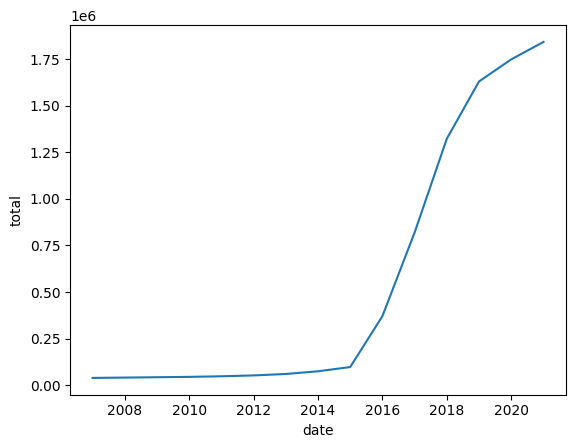

In [53]:
df_migration = pd.read_csv("/home/minigonche/Dropbox/Projects/malaria_mining/data/raw/population/venezulean_population.csv")
df_migration["date"] = df_migration.year.apply(lambda y : pd.to_datetime(f"{y}-01-01"))
df_migration = df_migration[["date","total"]].copy()
sns.lineplot(data = df_migration, x = "date", y = "total")

Casos Malaria (P.vivax)
Min: 1016
Max: 10549
--------

Casos Malaria (P.falciparum
Min: 497
Max: 6130
--------

Precio del Oro (Mercado Internacional)
Min: 630.1857125418527
Max: 1967.2952299572173
--------

Venezolanos Registrados en Colombia
Min: 39072
Max: 1842390
--------



Text(0.5, 1.0, 'Comparación de Variables (2007-2020)')

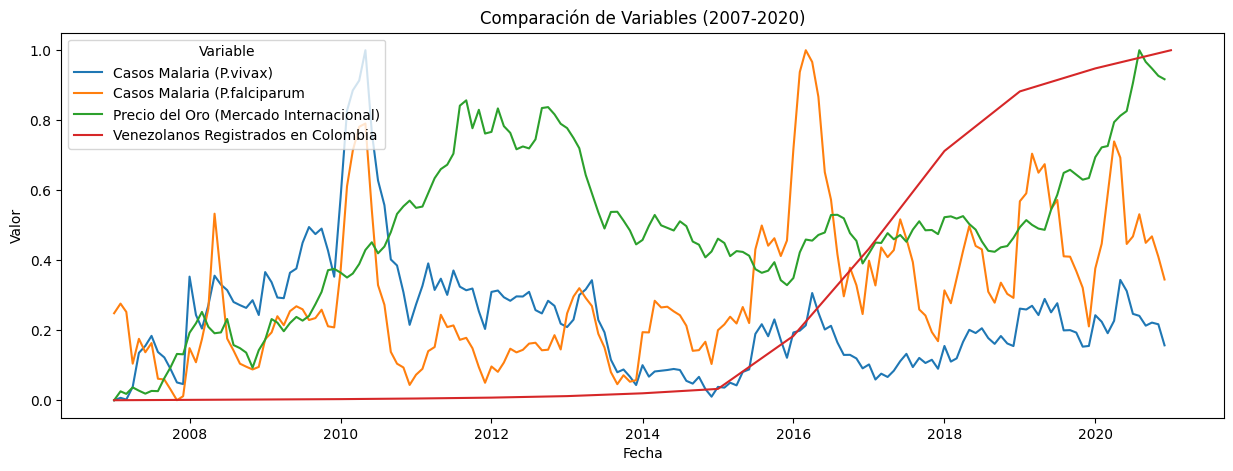

In [64]:

replace = {"MALARIA VIVAX" : "Casos Malaria (P.vivax)",
           "MALARIA FALCIPARUM" : "Casos Malaria (P.falciparum",
           "gold_stock_price" : "Precio del Oro (Mercado Internacional)",
           "gold_exports" : "Exportación de Oro Regulada",
           "total" : "Venezolanos Registrados en Colombia"}


dfs = [df_vivax_plot, df_falciparum_plot, df_gold_price, df_migration]

final_dfs = []
for df in dfs:

    df = df.copy()

    col_value = replace[df.columns[1]]
    df.columns = ["date","value"]
    df["event"] = col_value

    print(col_value)
    print(f"Min: {df.value.min()}")
    print(f"Max: {df.value.max()}")
    print("--------")
    print("")

    df.value = (df.value - df.value.min()) / (df.value.max() - df.value.min())

    final_dfs.append(df)



df_plot = pd.concat(final_dfs, ignore_index = True)

df_plot.columns = ["Fecha","Valor", "Variable"]
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data = df_plot, x = "Fecha", y = "Valor", hue = "Variable")
ax.set_title("Comparación de Variables (2007-2020)")

Text(0.5, 1.0, 'Malaria en Colombia (2007-2020)')

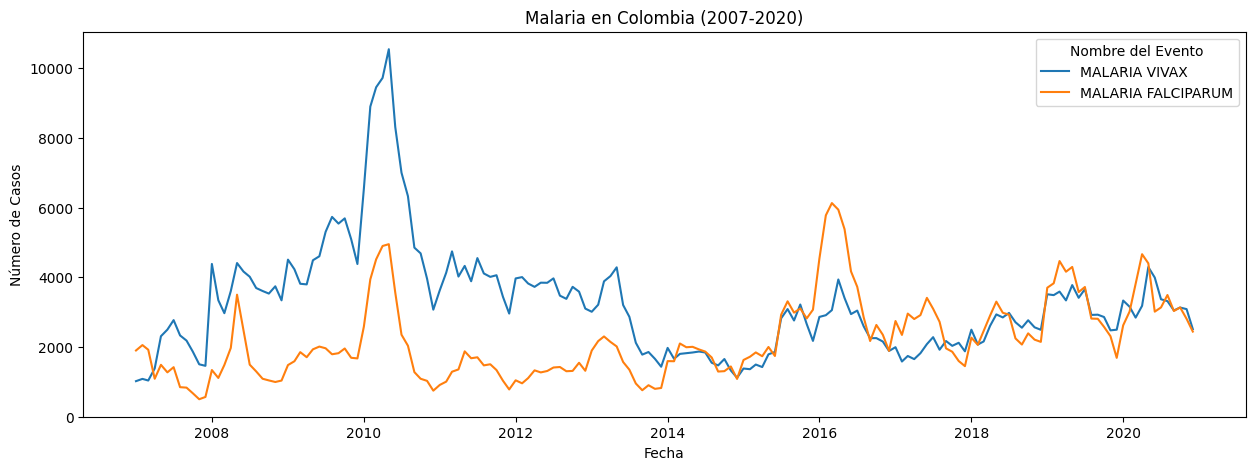

In [11]:
df_plot = df_malaria.copy()
df_plot = df_plot[["date","nombre_evento","num_cases"]].groupby(["date","nombre_evento"]).sum().reset_index()
df_plot = df_plot.sort_values("nombre_evento", ascending=False)

df_plot.columns = ["Fecha", "Nombre del Evento", "Número de Casos"]



plt.figure(figsize=(15, 5))
ax = sns.lineplot(data = df_plot, x = "Fecha", y = "Número de Casos", hue = "Nombre del Evento")
ax.set_title("Malaria en Colombia (2007-2020)")